In [3]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time

In [4]:
sdir='C:/Users/Hi/PycharmProjects/FYP2/Plant_leave_diseases_dataset_with_augmentation'
min_samples=40 # set limit for minimum images a class must have to be included in the dataframe
filepaths = []
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    else:
        print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  54308   test_df length:  3018   valid_df length:  3017
The number of classes in the dataset is:  38
            CLASS               IMAGE COUNT 
      Apple___Apple_scab            900     
      Apple___Black_rot             900     
   Apple___Cedar_apple_rust         900     
       Apple___healthy             1481     
     Blueberry___healthy           1352     
   Cherry___Powdery_mildew          947     
       Cherry___healthy             900     
Corn___Cercospora_leaf_spot Gray_leaf_spot      900     
      Corn___Common_rust           1073     
 Corn___Northern_Leaf_Blight        900     
        Corn___healthy             1046     
      Grape___Black_rot            1062     
 Grape___Esca_(Black_Measles)      1245     
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)      968     
       Grape___healthy              900     
Orange___Haunglongbing_(Citrus_greening)     4956     
    Peach___Bacterial_spot         2067     
       Peach___healthy              90

In [5]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=200 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=36
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  36


In [6]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,200) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  7600
Total Augmented images created=  0
Length of augmented dataframe is now  7600


C:\Users\Hi\AppData\Local\Temp/ipykernel_6800/1505794195.py:45: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Fseries=pd.Series(aug_fpaths, name='filepaths')
C:\Users\Hi\AppData\Local\Temp/ipykernel_6800/1505794195.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Lseries=pd.Series(aug_labels, name='labels')


In [7]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 7600 validated image filenames belonging to 38 classes.          for train generator 
Found 3017 validated image filenames belonging to 38 classes.          for valid generator 
Found 3018 validated image filenames belonging to 38 classes.          for test generator 
test batch size:  6   test steps:  503  number of classes :  38


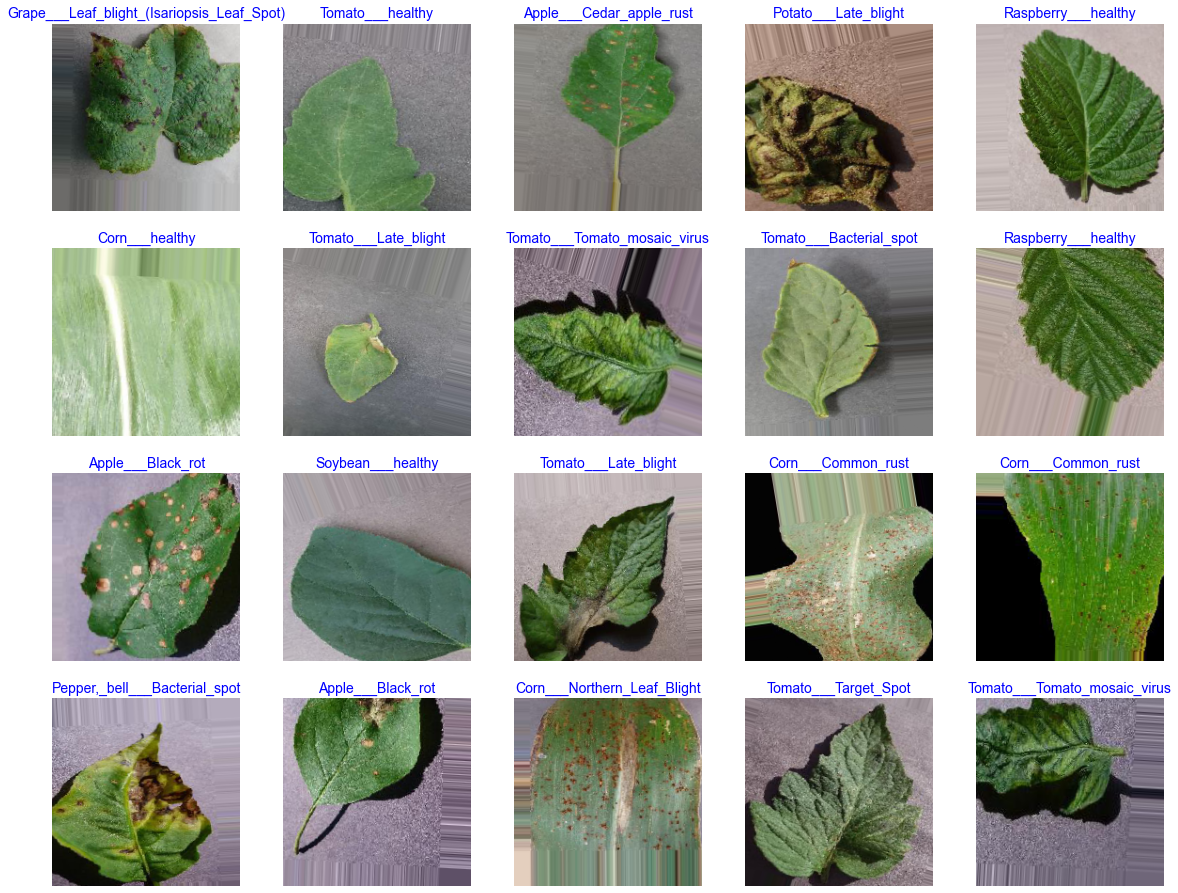

In [8]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

ResNet9 Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 112, 112, 64  256        ['conv2d_28[0][0]']              
 ormalization)                  )                                                             

 ormalization)                                                                                    
                                                                                                  
 add_15 (Add)                   (None, 28, 28, 128)  0           ['batch_normalization_36[0][0]', 
                                                                  'batch_normalization_37[0][0]'] 
                                                                                                  
 activation_33 (Activation)     (None, 28, 28, 128)  0           ['add_15[0][0]']                 
                                                                                                  
 conv2d_38 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_33[0][0]']          
                                                                                                  
 batch_normalization_38 (BatchN  (None, 28, 28, 128)  512        ['conv2d_38[0][0]']              
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 activation_42 (Activation)     (None, 14, 14, 256)  0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 conv2d_48 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_42[0][0]']          
                                                                                                  
 batch_normalization_48 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_20 (Add)                   (None, 14, 14, 256)  0           ['batch_normalization_48[0][0]', 
          

Epoch 4/10
380/380 [==============================] - 1345s 4s/step - loss: 1.1048 - accuracy: 0.6512 - val_loss: 2.7637 - val_accuracy: 0.3795
Epoch 5/10
380/380 [==============================] - 1333s 4s/step - loss: 0.9286 - accuracy: 0.7058 - val_loss: 0.8962 - val_accuracy: 0.7206
Epoch 6/10
380/380 [==============================] - 1140s 3s/step - loss: 0.8047 - accuracy: 0.7424 - val_loss: 0.9146 - val_accuracy: 0.7246
Epoch 7/10
380/380 [==============================] - 1179s 3s/step - loss: 0.7065 - accuracy: 0.7718 - val_loss: 1.8335 - val_accuracy: 0.5287
Epoch 8/10
380/380 [==============================] - 1262s 3s/step - loss: 0.6266 - accuracy: 0.7963 - val_loss: 6.8997 - val_accuracy: 0.2652
Epoch 9/10
380/380 [==============================] - 1194s 3s/step - loss: 0.5571 - accuracy: 0.8155 - val_loss: 6.7096 - val_accuracy: 0.2131
Epoch 10/10
503/503 [==============================] - 167s 332ms/step - loss: 0.7341 - accuracy: 0.7760
Test Loss: 0.7340599298477173
T

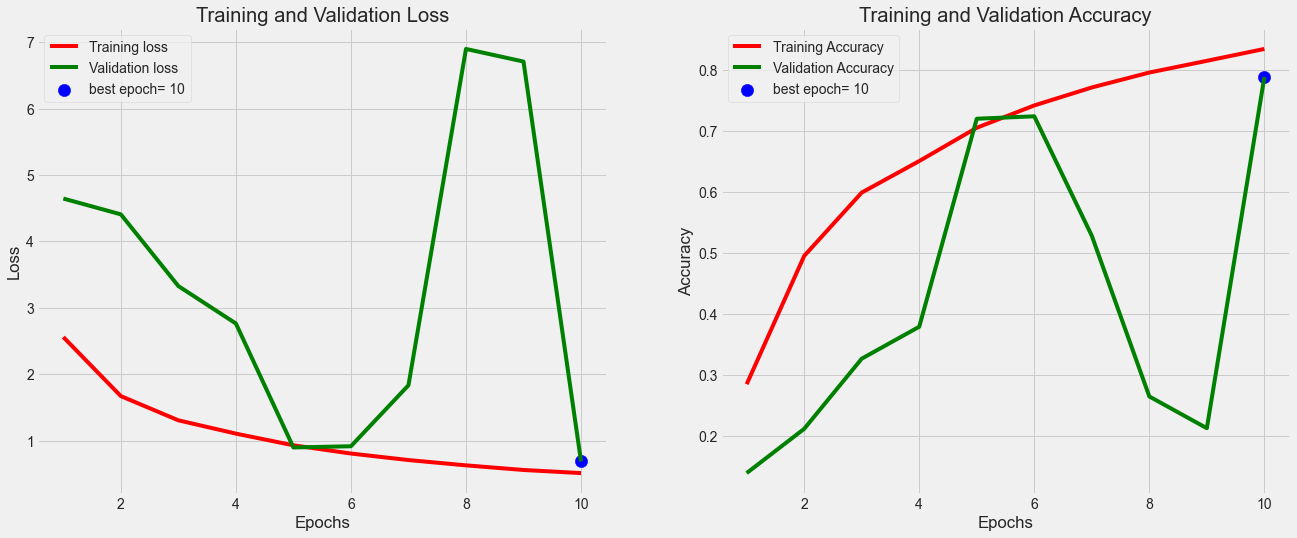

503/503 [==============================] - 167s 330ms/step
True Label: Orange___Haunglongbing_(Citrus_greening)
Predicted Label: Orange___Haunglongbing_(Citrus_greening)

True Label: Peach___healthy
Predicted Label: Peach___healthy

True Label: Pepper,_bell___Bacterial_spot
Predicted Label: Pepper,_bell___Bacterial_spot

True Label: Grape___Esca_(Black_Measles)
Predicted Label: Grape___Esca_(Black_Measles)

True Label: Orange___Haunglongbing_(Citrus_greening)
Predicted Label: Orange___Haunglongbing_(Citrus_greening)

There were 676 errors in 3018 tests for an accuracy of  77.60
Shape of y_true: (3018,)
Shape of y_pred: (3018,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     0.5952    1.0000    0.7463        50
                            Apple___Black_rot     0.4945    0.9000    0.6383        50
                     Apple___Cedar_apple_rust     0.9714

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, downsample=False):
    # Convolutional layers
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1 if not downsample else 2, 1 if not downsample else 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Downsample if needed
    if downsample:
        inputs = Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(inputs)
        inputs = BatchNormalization()(inputs)
    
    # Shortcut connection
    x = tf.keras.layers.add([x, inputs])
    x = Activation('relu')(x)
    
    return x

# Input layer
inputs = Input(shape=(224, 224, 3))

# Initial convolutional layer
x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

# Residual blocks
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)
x = resnet_block(x, filters=64)

x = resnet_block(x, filters=128, downsample=True)
x = resnet_block(x, filters=128)
x = resnet_block(x, filters=128)

x = resnet_block(x, filters=256, downsample=True)
x = resnet_block(x, filters=256)
x = resnet_block(x, filters=256)

x = resnet_block(x, filters=512, downsample=True)
x = resnet_block(x, filters=512)
x = resnet_block(x, filters=512)

# Global average pooling and dense layers for classification
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)  # Assuming num_classes is defined

# Create the ResNet9 model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 10  # Adjust the number of epochs as needed
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen, validation_steps=validation_steps)

# Evaluate the model on the test set
test_steps = len(test_gen)
loss, accuracy = model.evaluate(test_gen, steps=test_steps)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 5  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Print the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = Image.open(image_path)
                image.show()
                print(f"True Label: {classes[true_index]}")
                print(f"Predicted Label: {classes[pred_index]}\n")
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):  # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True  # if True query the user on a specified epoch
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()  # set best weights to model's initial weights
        self.best_epoch = 1

    def on_train_begin(self, logs=None):  # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:  # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask = False  # do not query the user
        if self.epochs == 1:
            self.ask = False  # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch, ' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()  # set the time at which training started

    def on_train_end(self, logs=None):  # runs at the end of training
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights)  # set the weights of the model to the best weights
        tr_duration = time.time() - self.start_time  # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)  # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()  # set best weights to model's initial weights
            self.best_epoch = epoch + 1
            print(
                f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print(
                f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')

        if self.ask:  # are the conditions right to query the user?
            if epoch + 1 == self.ask_epoch:  # is this epoch the one for quering the user?
                print(
                    '\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans == 'H' or ans == 'h' or ans == '0':  # quit training for these conditions
                    print('you entered ', ans, ' Training halted on epoch ', epoch + 1, ' due to user input\n',
                          flush=True)
                    self.model.stop_training = True  # halt training
                else:  # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ',
                              self.ask_epoch, flush=True)
                    else:
                        print('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans = input(' ')
                        if ans == '':
                            print(f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr = float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr,
                                                       new_lr)  # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [4]:
# Train the model
epochs = 20  # Adjust the number of epochs as needed
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen, validation_steps=validation_steps)

In [ ]:
# Evaluate the model on the test set
test_steps = len(test_gen)
loss, accuracy = model.evaluate(test_gen, steps=test_steps)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

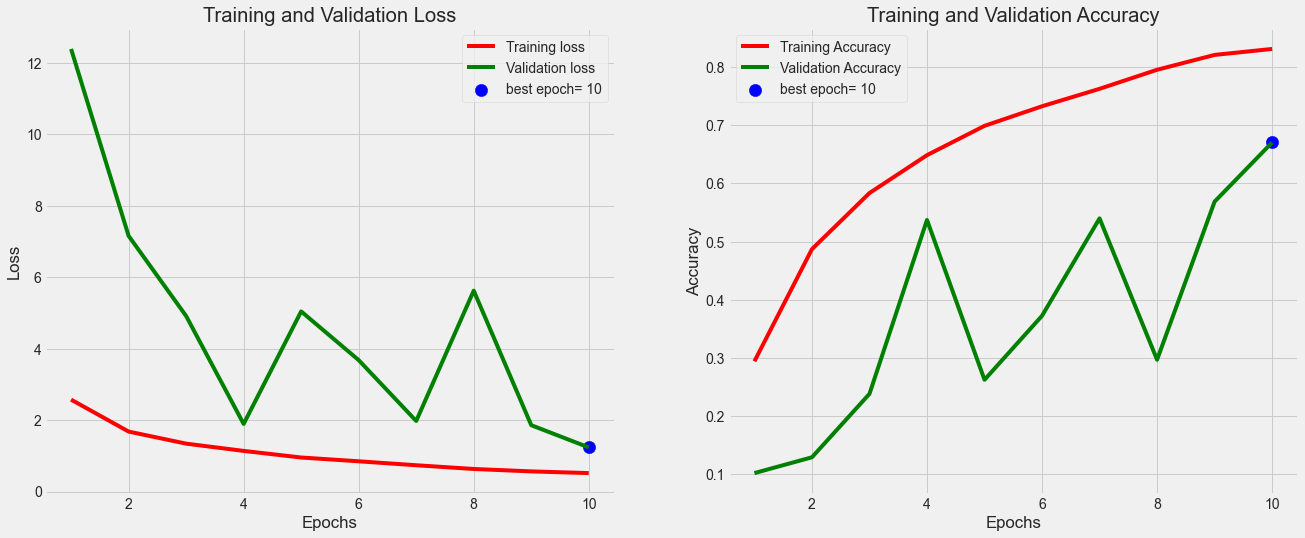

In [12]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 5  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Print the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = Image.open(image_path)
                image.show()
                print(f"True Label: {classes[true_index]}")
                print(f"Predicted Label: {classes[pred_index]}\n")
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)

503/503 [==============================] - 177s 349ms/step
True Label: Orange___Haunglongbing_(Citrus_greening)
Predicted Label: Orange___Haunglongbing_(Citrus_greening)

True Label: Peach___healthy
Predicted Label: Peach___healthy

True Label: Pepper,_bell___Bacterial_spot
Predicted Label: Pepper,_bell___Bacterial_spot

True Label: Grape___Esca_(Black_Measles)
Predicted Label: Blueberry___healthy

True Label: Orange___Haunglongbing_(Citrus_greening)
Predicted Label: Orange___Haunglongbing_(Citrus_greening)

There were 1029 errors in 3018 tests for an accuracy of  65.90
Shape of y_true: (3018,)
Shape of y_pred: (3018,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     0.7857    0.6600    0.7174        50
                            Apple___Black_rot     0.5116    0.8800    0.6471        50
                     Apple___Cedar_apple_rust     1.0000    0.42

ResNet50 Model

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Load pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers so that they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add your custom top classification layers
num_classes = len(train_gen.class_indices)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
#x = base_model.output
#x = Dense(256, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
#output = Dense(class_count, activation='softmax')(x)

# Create the final model with the custom top layers
#model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 38)                77862     
                                                                 
Total params: 23,665,574
Trainable params: 77,862
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)
epochs = 10

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen, validation_steps=validation_steps)

Epoch 1/10
380/380 [==============================] - 766s 2s/step - loss: 1.1398 - accuracy: 0.7066 - val_loss: 0.4235 - val_accuracy: 0.8850
Epoch 2/10
380/380 [==============================] - 750s 2s/step - loss: 0.4271 - accuracy: 0.8838 - val_loss: 0.3092 - val_accuracy: 0.9026
Epoch 3/10
380/380 [==============================] - 740s 2s/step - loss: 0.3286 - accuracy: 0.9045 - val_loss: 0.2616 - val_accuracy: 0.9205
Epoch 4/10
380/380 [==============================] - 732s 2s/step - loss: 0.2652 - accuracy: 0.9216 - val_loss: 0.2442 - val_accuracy: 0.9267
Epoch 5/10
380/380 [==============================] - 778s 2s/step - loss: 0.2244 - accuracy: 0.9336 - val_loss: 0.2171 - val_accuracy: 0.9307
Epoch 6/10
380/380 [==============================] - 764s 2s/step - loss: 0.1994 - accuracy: 0.9421 - val_loss: 0.2270 - val_accuracy: 0.9301
Epoch 7/10
380/380 [==============================] - 771s 2s/step - loss: 0.1819 - accuracy: 0.9428 - val_loss: 0.2223 - val_accuracy: 0.9370

In [11]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

503/503 [==============================] - 227s 452ms/step - loss: 0.2017 - accuracy: 0.9384
Test Loss: 0.20166592299938202
Test Accuracy: 0.9383698105812073


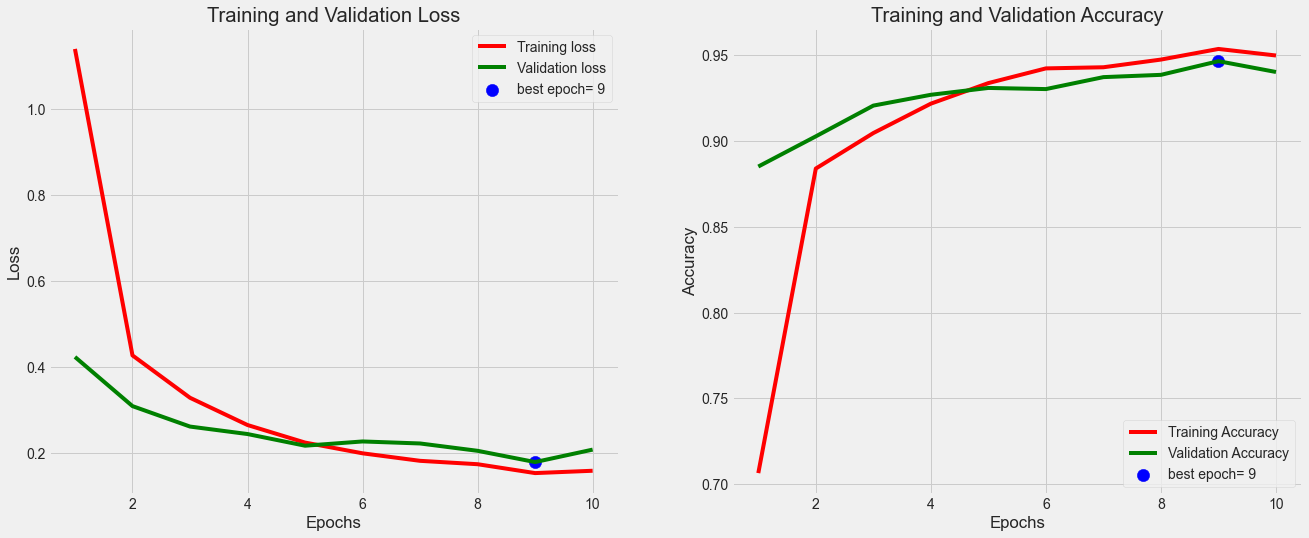

In [12]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

503/503 [==============================] - 234s 462ms/step


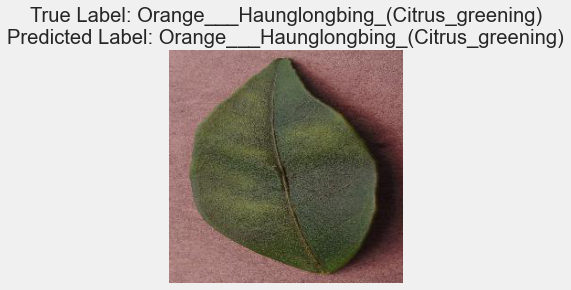

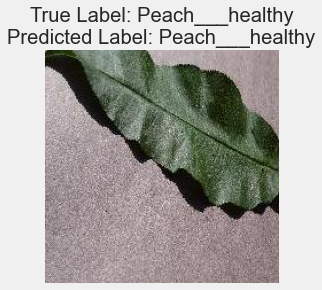

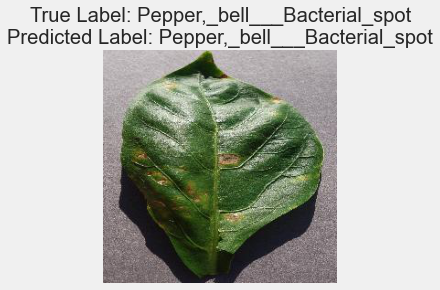

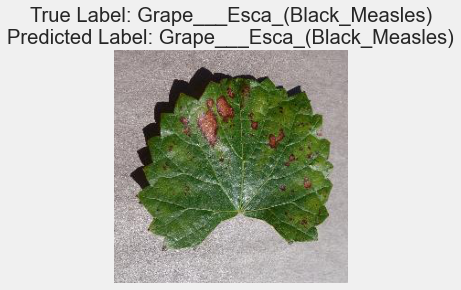

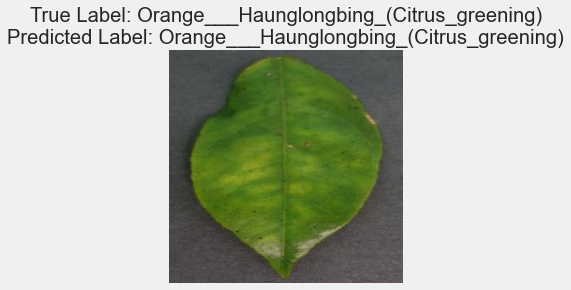

There were 186 errors in 3018 tests for an accuracy of  93.84
Shape of y_true: (3018,)
Shape of y_pred: (3018,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     0.9778    0.8800    0.9263        50
                            Apple___Black_rot     0.9615    1.0000    0.9804        50
                     Apple___Cedar_apple_rust     0.9804    1.0000    0.9901        50
                              Apple___healthy     0.9091    0.9756    0.9412        82
                          Blueberry___healthy     0.9868    1.0000    0.9934        75
                      Cherry___Powdery_mildew     1.0000    0.9423    0.9703        52
                             Cherry___healthy     1.0000    1.0000    1.0000        50
   Corn___Cercospora_leaf_spot Gray_leaf_spot     0.7778    0.9800    0.8673        50
                           Corn___Common_rust     1.0000 

In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 5  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Show the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = plt.imread(image_path)
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"True Label: {classes[true_index]}\nPredicted Label: {classes[pred_index]}")
                plt.show()
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)

ResNet-101 Model

In [15]:
!pip install tensorflow-addons

In [17]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load pre-trained ResNet-101 model without the top classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers so that they are not updated during training
base_model.trainable = False

# Add your custom top classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Replace `num_classes` with the number of classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block7_out[0][0]']       
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block8_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block8_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block10_out[0][0]']      
                                                                                                  
 conv4_block11_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block13_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block13_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block13_out[0][0]']      
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block16_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block17_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block16_out[0][0]']      
                                                                                                  
 conv4_block17_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block17_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block17_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block17_1_bn[0][0]']     
 on)      

                                )                                 'conv4_block19_3_bn[0][0]']     
                                                                                                  
 conv4_block19_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block19_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block19_out[0][0]']      
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block22_add (Add)        (None, 14, 14, 1024  0           ['conv4_block21_out[0][0]',      
                                )                                 'conv4_block22_3_bn[0][0]']     
                                                                                                  
 conv4_block22_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block22_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block22_out[0][0]']      
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
          

 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_blo

In [20]:
steps_per_epoch = len(train_gen)
validation_steps = len(valid_gen)
epochs = 10

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=valid_gen, validation_steps=validation_steps)

Epoch 1/10
380/380 [==============================] - 1290s 3s/step - loss: 0.9889 - accuracy: 0.7203 - val_loss: 0.3957 - val_accuracy: 0.8681
Epoch 2/10
380/380 [==============================] - 1345s 4s/step - loss: 0.3866 - accuracy: 0.8804 - val_loss: 0.4082 - val_accuracy: 0.8823
Epoch 3/10
380/380 [==============================] - 1267s 3s/step - loss: 0.3150 - accuracy: 0.8979 - val_loss: 0.3403 - val_accuracy: 0.8910
Epoch 4/10
380/380 [==============================] - 1324s 3s/step - loss: 0.2714 - accuracy: 0.9093 - val_loss: 0.3482 - val_accuracy: 0.8830
Epoch 5/10
380/380 [==============================] - 1191s 3s/step - loss: 0.2486 - accuracy: 0.9178 - val_loss: 0.3006 - val_accuracy: 0.9085
Epoch 6/10
380/380 [==============================] - 1632s 4s/step - loss: 0.1996 - accuracy: 0.9330 - val_loss: 0.4461 - val_accuracy: 0.8717
Epoch 7/10
380/380 [==============================] - 2018s 5s/step - loss: 0.1992 - accuracy: 0.9376 - val_loss: 0.3359 - val_accuracy:

In [21]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

503/503 [==============================] - 466s 923ms/step - loss: 0.2320 - accuracy: 0.9241
Test Loss: 0.23198182880878448
Test Accuracy: 0.9241219162940979


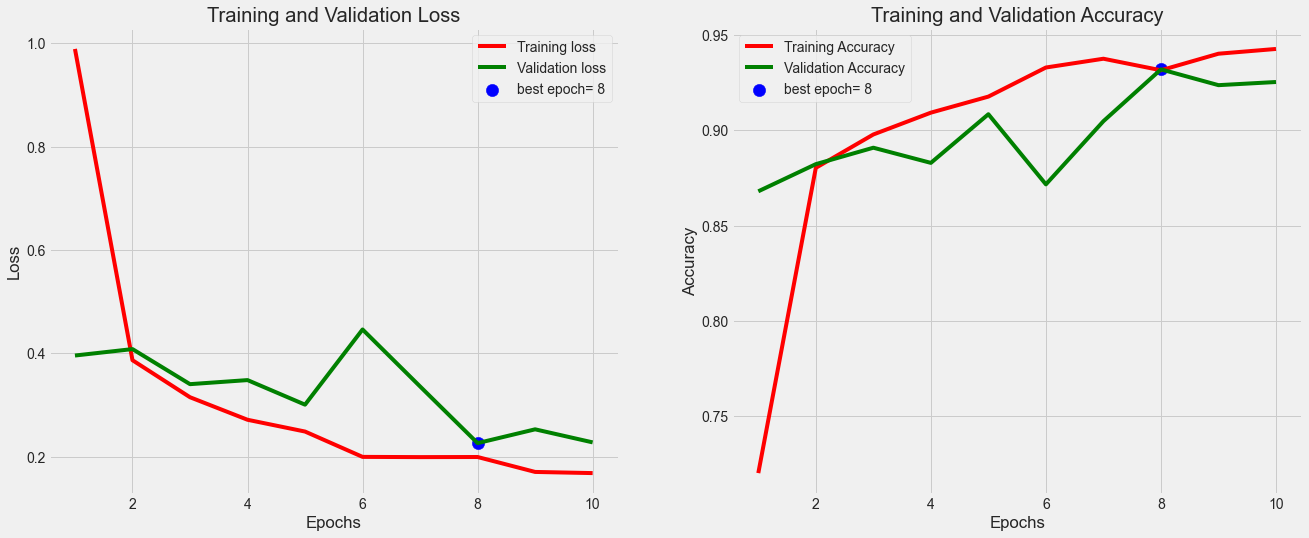

In [22]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()


tr_plot(history, 0)

503/503 [==============================] - 478s 936ms/step


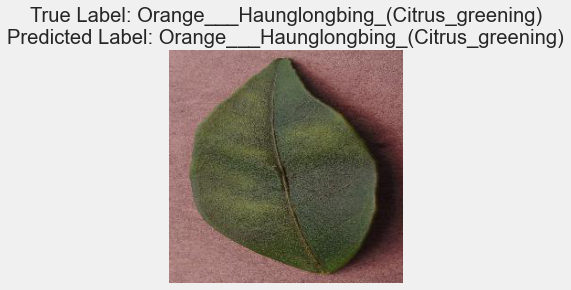

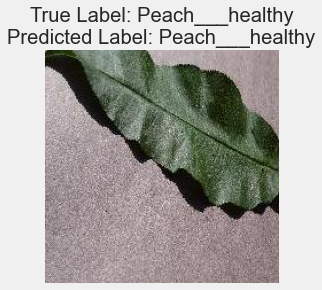

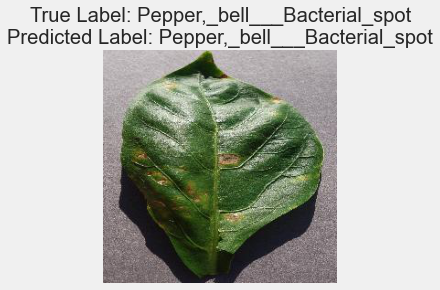

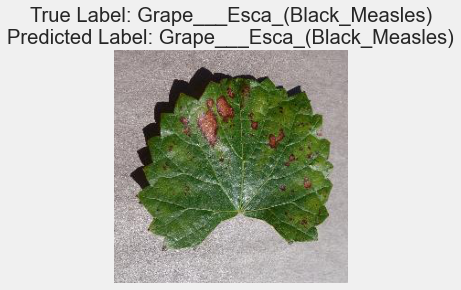

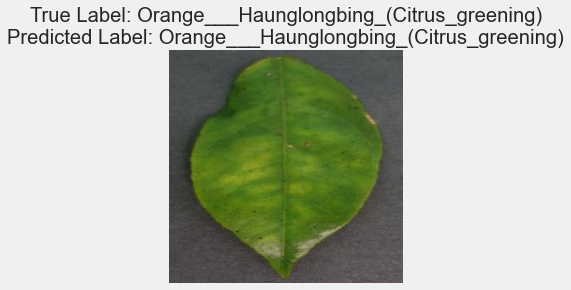

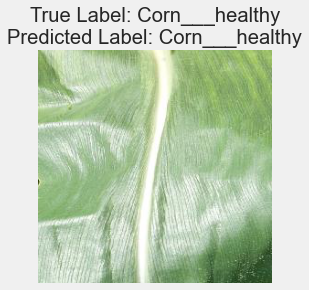

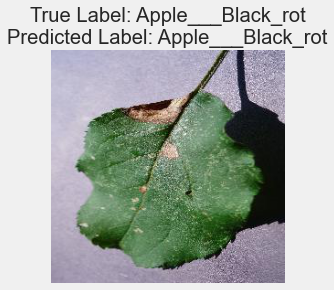

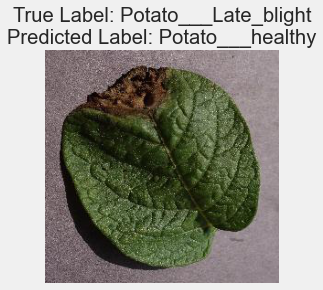

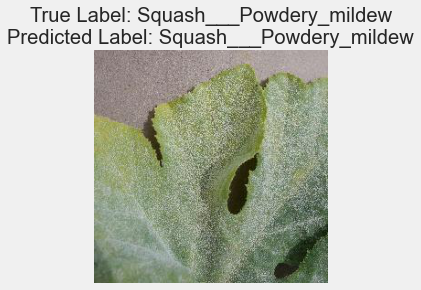

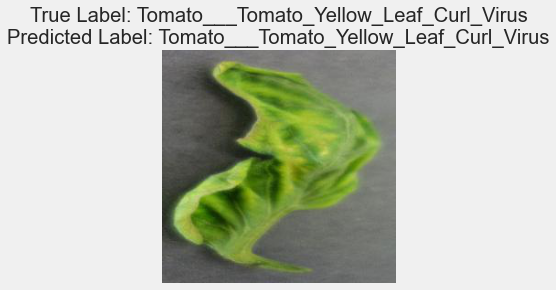

There were 229 errors in 3018 tests for an accuracy of  92.41
Shape of y_true: (3018,)
Shape of y_pred: (3018,)
Classification Report:
----------------------
                                                precision    recall  f1-score   support

                           Apple___Apple_scab     1.0000    0.7200    0.8372        50
                            Apple___Black_rot     0.9245    0.9800    0.9515        50
                     Apple___Cedar_apple_rust     0.9804    1.0000    0.9901        50
                              Apple___healthy     0.8438    0.9878    0.9101        82
                          Blueberry___healthy     0.9615    1.0000    0.9804        75
                      Cherry___Powdery_mildew     1.0000    0.8462    0.9167        52
                             Cherry___healthy     1.0000    0.9600    0.9796        50
   Corn___Cercospora_leaf_spot Gray_leaf_spot     0.9750    0.7800    0.8667        50
                           Corn___Common_rust     0.9672 

In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels[:len(test_gen.filenames)]  # Slice y_true to match the length of y_pred
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)
    
    image_limit = 10  # Limit the number of predicted images shown
    image_count = 0  # Counter for the number of predicted images displayed
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = y_true[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            errors += 1
        y_pred.append(pred_index)

        # Show the predicted image, true label, and predicted label
        if image_count < image_limit:
            try:
                image_path = test_gen.filepaths[i]
                image = plt.imread(image_path)
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"True Label: {classes[true_index]}\nPredicted Label: {classes[pred_index]}")
                plt.show()
                
                image_count += 1  # Increment the counter for displayed images
            except Exception as e:
                print(f"Error displaying image: {e}")
    
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)
    
    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests

# Call the predictor function
errors, tests = predictor(test_gen, test_steps)